# MobileNetV2

1. Default learning rate (0.001 of RMSprop optimizer).
2. Layer dense with 512 nodes.
3. Activation function 'relu' and softmax for the last layer.
4. Dropout 0.5.
5. Data Augmentation.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
import zipfile
from shutil import copyfile
from time import time
import numpy as np
import random as python_random
from tensorflow.keras import layers

np.random.seed(0)
python_random.seed(0)
tf.random.set_seed(0)

In [3]:
import urllib.request
import tarfile

# URL del dataset
url = "http://download.tensorflow.org/example_images/flower_photos.tgz"

# Percorso di destinazione per il download
file_name = "flower_photos.tgz"

# Download del file
urllib.request.urlretrieve(url, file_name)

# Estrazione del file
tar = tarfile.open(file_name)
tar.extractall()
tar.close()

In [4]:
!pip install split-folders
import splitfolders
splitfolders.ratio('flower_photos', output="output", seed=1337, ratio=(0.7, 0.2, 0.1))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 3670 files [00:00, 4076.96 files/s]


In [5]:
import shutil
shutil.make_archive('/content/drive/MyDrive/flower_photos/output', 'zip', 'output')

'/content/drive/MyDrive/flower_photos/output.zip'

In [6]:
path_train='/content/output/train/'
path_val='/content/output/val/'
path_test='/content/output/test/'

**Defiisco train, validation e test set**

Train dataset

In [7]:
train_dataset = keras.preprocessing.image_dataset_from_directory(path_train,
                                                                 image_size=(224,224),
                                                                 color_mode='rgb',
                                                                 label_mode='categorical',
                                                                 batch_size=32,
                                                                 validation_split = False,
                                                                 shuffle=True,
                                                                 seed=1)


Found 2567 files belonging to 5 classes.


In [8]:
val_dataset = keras.preprocessing.image_dataset_from_directory(path_val,
                                                                 image_size=(224,224),
                                                                 color_mode='rgb',
                                                                 label_mode='categorical',
                                                                 batch_size=32,
                                                                 validation_split = False,
                                                                 shuffle=True,
                                                                 seed=1)


Found 731 files belonging to 5 classes.


In [9]:
test_dataset = keras.preprocessing.image_dataset_from_directory(path_test,
                                                                 image_size=(224,224),
                                                                 color_mode='rgb',
                                                                 label_mode='categorical',
                                                                 batch_size=32,
                                                                 validation_split = False,
                                                                 shuffle=True,
                                                                 seed=1)

Found 372 files belonging to 5 classes.


**Visualizing Data**

In [10]:
class_names = train_dataset.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [11]:
num_classes=5

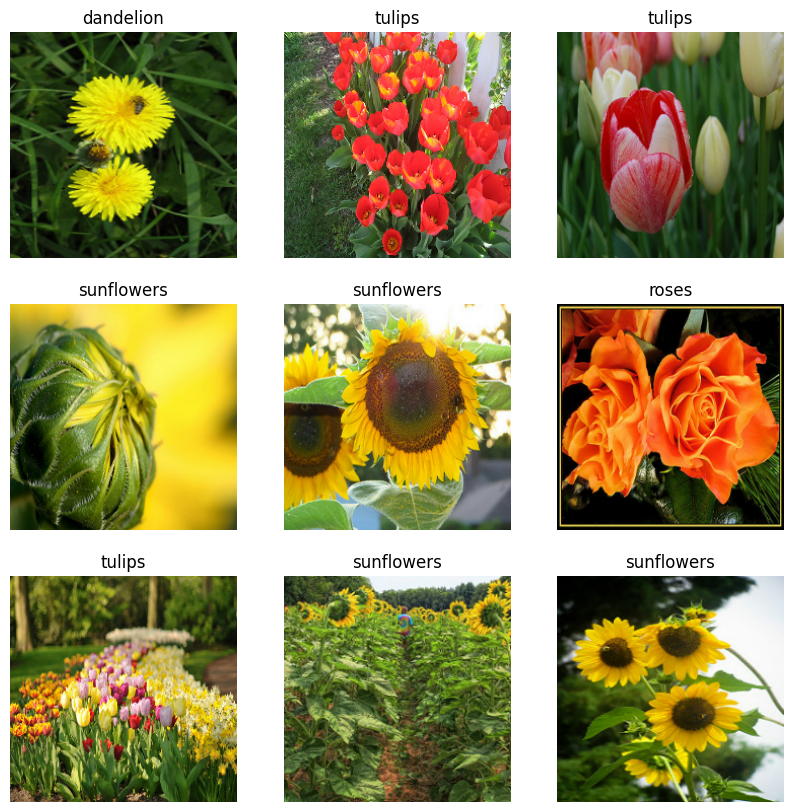

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i], axis=None, out=None)])
    plt.axis("off")

**Image Data Augmentation**

In [13]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

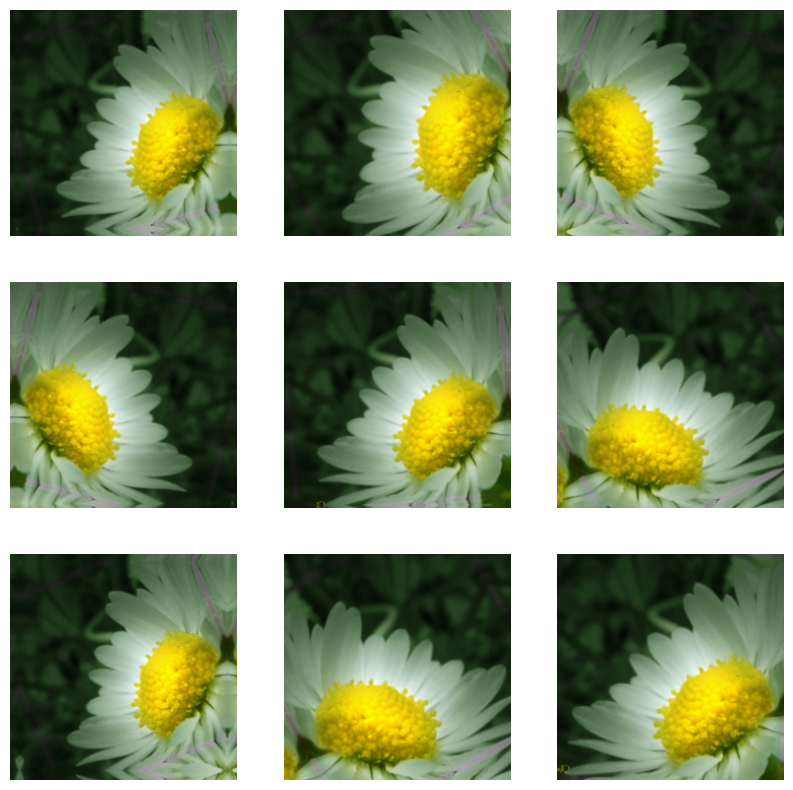

In [14]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[1]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

**MobileNetV2 architecture**

In [15]:
# Base model
base_net = keras.applications.MobileNetV2(input_shape=(224,224,3), weights='imagenet', include_top=False, pooling='max')

9406464/9406464 [==============================] - 0s 0us/step


In [16]:
# Freezing the base model (only for finetuning a pretrained model)
for layer in base_net.layers:
    layer.trainable = False

In [17]:
inputs = keras.Input(shape=(224, 224, 3))
x = inputs
x = data_augmentation(x)
x = keras.applications.mobilenet_v2.preprocess_input(x)
x = base_net(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
netV2 = keras.Model(inputs=inputs, outputs=outputs)

In [18]:
# Compile the model for training
netV2.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(),
            metrics=['accuracy'])

In [19]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


In [20]:
# Model training
history= netV2.fit(train_dataset,
                 epochs=40,
                 validation_data=val_dataset, callbacks=[callback]);

Epoch 1/40
81/81 [==============================] - 30s 123ms/step - loss: 3.0967 - accuracy: 0.5898 - val_loss: 0.7515 - val_accuracy: 0.7332
Epoch 2/40
81/81 [==============================] - 7s 85ms/step - loss: 0.9199 - accuracy: 0.7121 - val_loss: 0.4790 - val_accuracy: 0.8194
Epoch 3/40
81/81 [==============================] - 9s 109ms/step - loss: 0.7890 - accuracy: 0.7596 - val_loss: 0.5598 - val_accuracy: 0.8098
Epoch 4/40
81/81 [==============================] - 8s 93ms/step - loss: 0.7032 - accuracy: 0.7756 - val_loss: 0.5969 - val_accuracy: 0.8181
Epoch 5/40
81/81 [==============================] - 7s 88ms/step - loss: 0.6500 - accuracy: 0.7963 - val_loss: 0.5839 - val_accuracy: 0.8263
Epoch 6/40
81/81 [==============================] - 10s 118ms/step - loss: 0.5876 - accuracy: 0.8037 - val_loss: 0.4293 - val_accuracy: 0.8440
Epoch 7/40
81/81 [==============================] - 9s 109ms/step - loss: 0.5375 - accuracy: 0.8422 - val_loss: 0.3827 - val_accuracy: 0.8591
Epoch 8

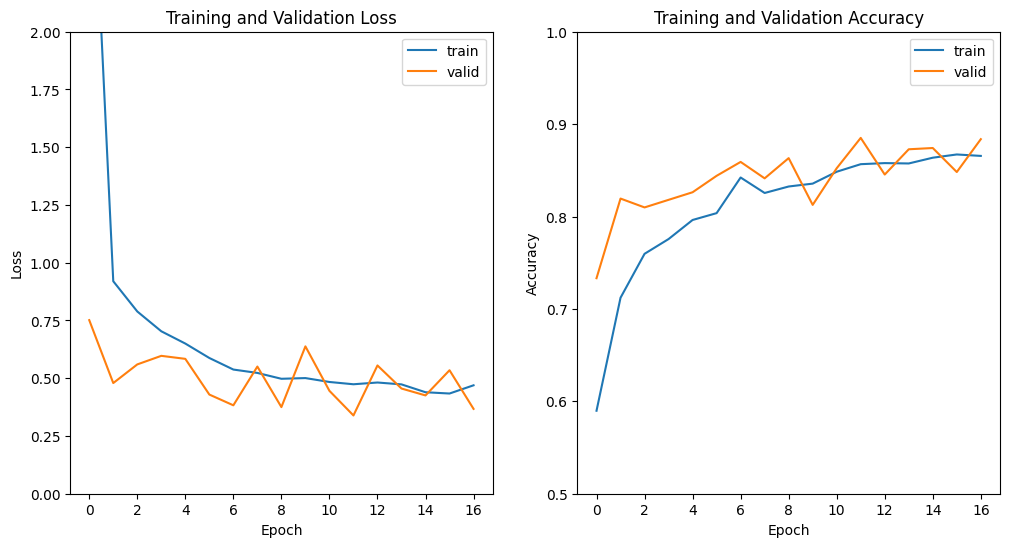

In [21]:
# Visualization of the learning curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0.0, 2.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])
plt.title('Training and Validation Loss');

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.5, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])
plt.title('Training and Validation Accuracy');

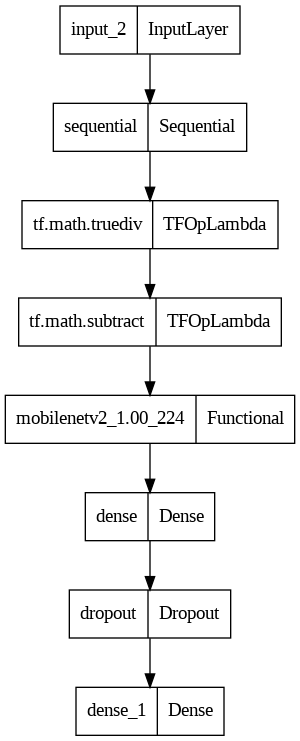

In [22]:
keras.utils.plot_model(netV2, to_file="netV2.png")

In [23]:
netV2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                             

**Evaluation on test set**

In [24]:
loss, accuracy = netV2.evaluate(test_dataset)

12/12 [==============================] - 2s 99ms/step - loss: 0.4162 - accuracy: 0.8763


**Save the model**

In [26]:
netV2.save('drive/MyDrive/MobileNetV2.h5')

**Misclassified images**

In [27]:
errate=0
total_images=0
for images, labels in test_dataset:
    for i in range(min(32, len(images))):
        predictions = netV2.predict(tf.expand_dims(images[i], 0))
        score = tf.nn.softmax(predictions[0])
        if class_names[np.argmax(score)] != class_names[np.argmax(labels[i], axis=None, out=None)]:
            errate += 1
        total_images+=1
print(errate)
print(total_images)

1/1 [==============================] - 0s 23ms/step
46
372


**Plot missclassified images**

1/1 [==============================] - 0s 42ms/step


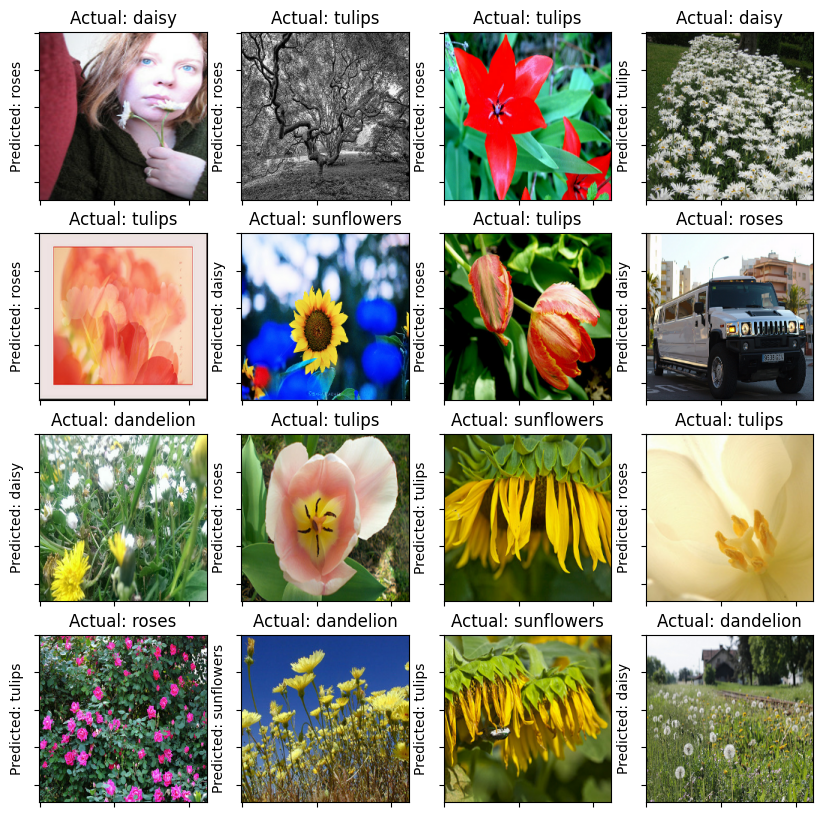

In [28]:
j = 0
plt.figure(figsize=(10, 10))
for images, labels in test_dataset:
    for i in range(32):
        predictions = netV2.predict(tf.expand_dims(images[i], 0))
        score = tf.nn.softmax(predictions[0])
        if class_names[np.argmax(score)] != class_names[np.argmax(labels[i], axis=None, out=None)]:
            if j >= 16:
                break
            ax = plt.subplot(4, 4, j + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.ylabel("Predicted: " + class_names[np.argmax(score)])
            plt.title("Actual: " + class_names[np.argmax(labels[i], axis=None, out=None)])
            plt.gca().axes.yaxis.set_ticklabels([])
            plt.gca().axes.xaxis.set_ticklabels([])
            j += 1
